## General Mixture Models

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

It is frequently the case that the data you have is not explained by a single underlying distribution. Typically this is because there are multiple phenomena occuring in the data set, each with their own underlying distribution.  If we want to try to recover the underlying distributions, we need to have a model which has multiple components. An example could be sensor readings where the majority of the time a sensor shows no signal, but sometimes it detects some phenomena. Modeling both phenomena as a single distribution would be silly because the readings would come from two distinct phenomena.

A solution to the problem of having more than one single underlying distribution is to use a mixture of distributions instead of a single distribution, commonly called a mixture model. This type of compositional model builds a more complex probability distribution from a set of simpler ones. A common type, called a Gaussian Mixture Model, is composed of Gaussian distributions, but mathematically there is no need for these distributions to all be Gaussian. In fact, there is no need for these distributions to be simple probability distributions.

In this tutorial we'll explore how to do mixture modeling in pomegranate, compare against scikit-learn's implementation of Gaussian mixture models, and explore more complex types of mixture modeling that one can do with probabilistic modeling.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy

from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

# %load_ext watermark
# %watermark -m -n -p numpy,scipy,pomegranate

### A simple example: Gaussian mixture models

Let's start off with a simple example. Perhaps we have a data set like the one below, which is made up of not a single blob, but many blobs. It doesn't seem like any of the simple distributions that pomegranate has implemented can fully capture what's going on in the data.

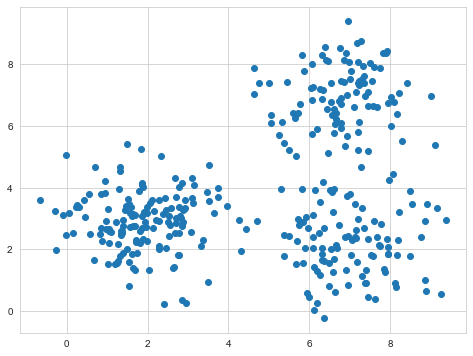

In [4]:
X = numpy.concatenate([numpy.random.normal((7, 2), 1, size=(100, 2)),
                       numpy.random.normal((2, 3), 1, size=(150, 2)),
                       numpy.random.normal((7, 7), 1, size=(100, 2))])

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1])
plt.show()

It seems clear to us that this data is composed of three blobs. Accordingly, rather than trying to find some complex single distribution that can describe this data, we can describe it as a mixture of three Gaussian distributions. In the same way that we could initialize a basic distribution using the `from_samples` method, we can initialize a mixture model using it, additionally passing in the type(s) of distribution(s) to use and the number of components.

In [5]:
model = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 3, X)

Now we can look at the probability densities if we had used a single Gaussian distribution versus using this mixture of three Gaussian models.

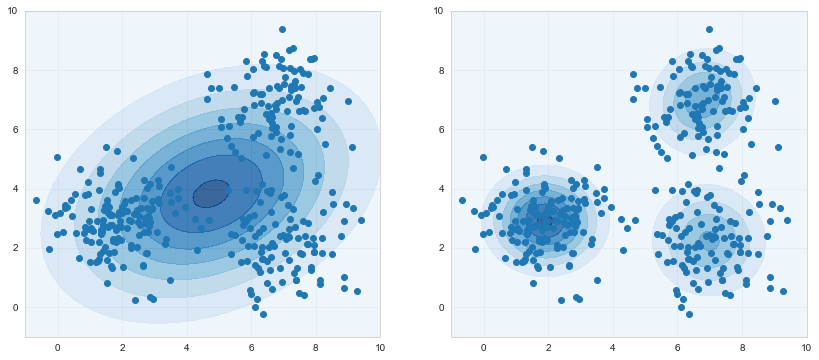

In [6]:
x = numpy.arange(-1, 10.1, .1)
y = numpy.arange(-1, 10.1, .1)

xx, yy = numpy.meshgrid(x, y)
x_ = numpy.array(list(zip(xx.flatten(), yy.flatten())))

p1 = MultivariateGaussianDistribution.from_samples(X).probability(x_).reshape(len(x), len(y))
p2 = model.probability(x_).reshape(len(x), len(y))


plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.contourf(xx, yy, p1, cmap='Blues', alpha=0.8)
plt.scatter(X[:,0], X[:,1])

plt.subplot(122)
plt.contourf(xx, yy, p2, cmap='Blues', alpha=0.8)
plt.scatter(X[:,0], X[:,1])
plt.show()

It looks like, unsurprisingly, the mixture model is able to better capture the structure of the data. The single model is so bad that the region of highest density (the darkest blue ellipse) has very few real points in it. In contrast, the darkest regions in the mixture densities correspond to where there are the most points in the clusters.

### A more complex example: independent component mixture models

Most data is more complex than the Gaussian case above. A common case in the domain of signal processing is analyzing segments of steady signal based on the mean, noise, and duration of each segment. Let's say that we have a signal like the following which is made up of long low-noise signals and shorter high-noise signals.

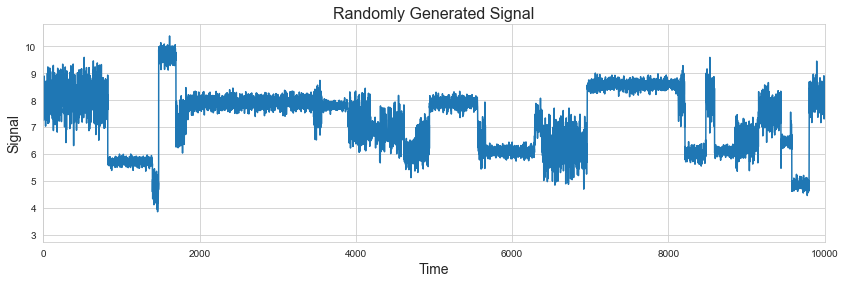

In [7]:
mu = numpy.random.normal(7, 1, size=250)

std = numpy.random.lognormal(-2.0, 0.4, size=250)
std[::2] += 0.3

dur = numpy.random.exponential(250, size=250)
dur[::2] -= 140
dur = numpy.abs(dur)

data = numpy.concatenate([numpy.random.normal(mu_, std_, int(t)) for mu_, std_, t in zip(mu, std, dur)])

plt.figure(figsize=(14, 4))
plt.title("Randomly Generated Signal", fontsize=16)
plt.plot(data)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Signal", fontsize=14)
plt.xlim(0, 10000)
plt.show()

We can show the distribution of segment properties to highlight the differences.

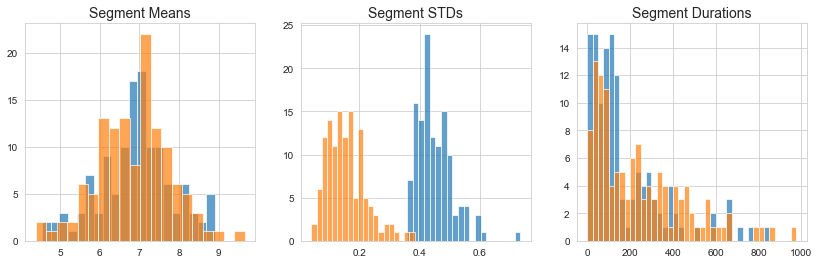

In [8]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title("Segment Means", fontsize=14)
plt.hist(mu[::2], bins=20, alpha=0.7)
plt.hist(mu[1::2], bins=20, alpha=0.7)

plt.subplot(132)
plt.title("Segment STDs", fontsize=14)
plt.hist(std[::2], bins=20, alpha=0.7)
plt.hist(std[1::2], bins=20, alpha=0.7)

plt.subplot(133)
plt.title("Segment Durations", fontsize=14)
plt.hist(dur[::2], bins=numpy.arange(0, 1000, 25), alpha=0.7)
plt.hist(dur[1::2], bins=numpy.arange(0, 1000, 25), alpha=0.7)
plt.show()

In this situation, it looks like the segment noise is going to be the feature with the most difference between the learned distributions. Let's use pomegranate to learn this mixture, modeling each feature with an appropriate distribution.

In [9]:
X = numpy.array([mu, std, dur]).T.copy()

model = GeneralMixtureModel.from_samples([NormalDistribution, LogNormalDistribution, ExponentialDistribution], 2, X)
model

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "IndependentComponentsDistribution",
            "parameters" : [
                [
                    {
                        "class" : "Distribution",
                        "name" : "NormalDistribution",
                        "parameters" : [
                            6.860875394747596,
                            0.9160039638844738
                        ],
                        "frozen" : false
                    },
                    {
                        "class" : "Distribution",
                        "name" : "LogNormalDistribution",
                        "parameters" : [
                            -1.937808134792027,
                            0.42934506977962006
                        ],
                        "frozen" : false
                    },
                    {
                        "class" : "Distribution",
 

It looks like the model is easily able to fit the differences that we observed in the data. The durations of the two components are similar, the means are almost identical to each other, but it's the noise that's the most different between the two.

## The API

### Initialization

The API for general mixture models is similar to that of the rest of pomegranate. The model can be initialized either through passing in some pre-initialized distributions or by calling `from_samples` on a data set, specifying the types of distributions you'd like. 

You can simply pass in some distributions to initialize the mixture.

In [10]:
model = GeneralMixtureModel([NormalDistribution(4, 1), NormalDistribution(7, 1)])

There is no reason these distributions have to be the same type. You can create a non-homogenous mixture by passing in different types of distributions.

In [11]:
model2 = GeneralMixtureModel([NormalDistribution(5, 1), ExponentialDistribution(0.3)])

They will produce very different probability distributions, but both work as a mixture.

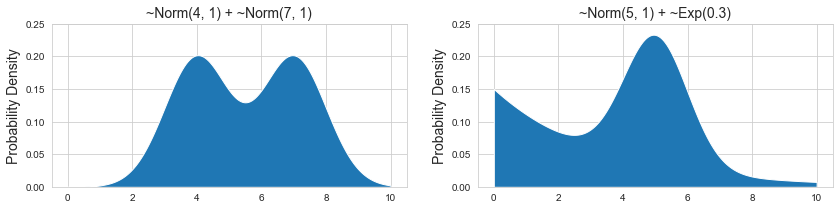

In [12]:
x = numpy.arange(0, 10.01, 0.05)

plt.figure(figsize=(14, 3))
plt.subplot(121)
plt.title("~Norm(4, 1) + ~Norm(7, 1)", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.fill_between(x, 0, model.probability(x))
plt.ylim(0, 0.25)

plt.subplot(122)
plt.title("~Norm(5, 1) + ~Exp(0.3)", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.fill_between(x, 0, model2.probability(x))
plt.ylim(0, 0.25)
plt.show()

pomegranate offers a lot of flexibility when it comes to making mixtures directly from data. The normal option is just to specify the type of distribution, the number of components, and then pass in the data. Make sure that if you're making 1 dimensional data that you're still passing in a matrix whose second dimension is just set to 1.

In [13]:
X = numpy.random.normal(3, 1, size=(200, 1))
X[::2] += 3

model = GeneralMixtureModel.from_samples(NormalDistribution, 2, X)

We can take a quick look at what it looks like:

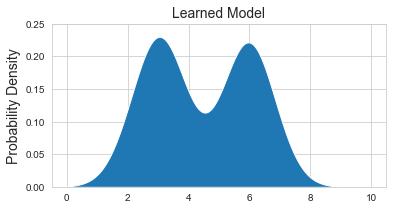

In [14]:
plt.figure(figsize=(6, 3))
plt.title("Learned Model", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.fill_between(x, 0, model.probability(x))
plt.ylim(0, 0.25)
plt.show()

However, we can also fit a non-homogenous mixture by passing in a list of univariate distributions to be fit to univariate data. Let's try to fit to data of which some of it is normally distributed and some is exponentially distributed. 

In [15]:
X = numpy.concatenate([numpy.random.normal(5, 1, size=(200, 1)), numpy.random.exponential(1, size=(50, 1))])

model = GeneralMixtureModel.from_samples([NormalDistribution, ExponentialDistribution], 2, X)

In [21]:
X

array([[4. ],
       [4.5],
       [5. ],
       [5.5],
       [6. ],
       [6.5],
       [7. ],
       [7.5],
       [8. ],
       [8.5]])

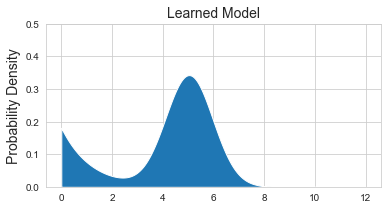

In [16]:
x = numpy.arange(0, 12.01, 0.01)

plt.figure(figsize=(6, 3))
plt.title("Learned Model", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.fill_between(x, 0, model.probability(x))
plt.ylim(0, 0.5)
plt.show()

It looks like the mixture is capturing the distribution fairly well.

Next, if we want to make a mixture model that describes each feature using a different distribution, we can pass in a list of distributions---one or each feature---and it'll use that distribution to model the corresponding feature. For example, in the example below, the first feature will be modeled using a normal distribution, the second feature will be modeled using a log normal distribution, and the last feature will be modeled using an exponential distribution.

In [17]:
X = numpy.array([mu, std, dur]).T.copy()

model = GeneralMixtureModel.from_samples([NormalDistribution, LogNormalDistribution, ExponentialDistribution], 2, X)

This is the same command we used in the second example. It creates two components, each of which model the three features respectively with those three distributions. The difference between this and the previous example is that the data here is multivariate and so univariate distributions are assumed to model different distributions.

### Prediction

Now that we have a mixture model, we can make predictions as to which component it is most likely to fall under. This is similar to the situation in which you predict which cluster a point falls under in k-means clustering. However, one of the benefits of using probabilistic models is that we can get a softer assignment of points based on probability, rather than a hard assignment to clusters for each point. 

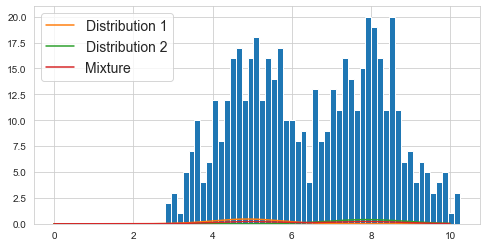

In [29]:
X = numpy.random.normal(5, 1, size=(500, 1))
X[::2] += 3

x = numpy.arange(0, 10, .01)

model = GeneralMixtureModel.from_samples(NormalDistribution, 2, X)

plt.figure(figsize=(8, 4))
plt.hist(X, bins=50)
plt.plot(x, model.distributions[0].probability(x), label="Distribution 1")
plt.plot(x, model.distributions[1].probability(x), label="Distribution 2")
plt.plot(x, model.probability(x), label="Mixture")
plt.legend(fontsize=14, loc=2)
plt.show()

The prediction task is identifying, for each point, whether it falls under the orange distribution or the green distribution. This is done using Bayes' rule, where the probability of each sample under each component is divided by the probability of the sample under all components of the mixture. The posterior probability of a sample belonging to component $i$ out of $k$ components is

\begin{equation}
P(M_{i}|D) = \frac{P(D|M_{i})P(M_{i})}{\sum\limits_{i=1}^{k} P(D|M_{i})P(M_{i})}
\end{equation}

where $D$ is the data, $M_{i}$ is the component of the model (such as the green or orange distributions), $P(D|M_{i}$ is the likelihood calculated by the `probability` function, $P(M_{i})$ is the prior probability of each component, stored under the `weights` attribute of the model, and $P(M_{i}|D)$ is the posterior probability that sums to 1 over all components.

We can calculate these posterior probabilites using the `predict_proba` method.

In [20]:
X = numpy.arange(4, 9, 0.5).reshape(10, 1)

model.predict_proba(X)

array([[0.00077546, 0.99922454],
       [0.00342627, 0.99657373],
       [0.01491466, 0.98508534],
       [0.06215941, 0.93784059],
       [0.22385609, 0.77614391],
       [0.55508699, 0.44491301],
       [0.84288655, 0.15711345],
       [0.9582144 , 0.0417856 ],
       [0.98984129, 0.01015871],
       [0.99757608, 0.00242392]])

As we scan from left to right, we can see that the probability of the first component (in orange) decreases, while the probability of the second component increases. This makes sense, because the green component is centered at a higher value. The posterior probability is not the probability of the point given the distribution, but rather the probability of the distribution given the point, i.e., which component is more likely to have generated the distribution. 